In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score
import seaborn as sns
from lets_plot import *

# 1. Несбалансированные выборки


In [3]:
y_true = [0]*900 + [1]*100
y_pred_0 = [0]*1000 # все классифицировали как 0
y_pred_1 = [1]*1000 # все классифицировали как 1
y_pred_10_both = [0]*810 + [1]*90 + [1]*90 + [0]*10 # по 10% каждого класса классифицированно неверно
y_pred_10_0 = [0]*810 + [1]*90 + [1]*100 # 10% класса 0 классифицированно с ошибкой
y_pred_10_1 = [0]*900 + [0]*10 + [1]*90 # 10% класса 1 классифицированно с ошибкой

y_pred = {'all 0': y_pred_0,
          'all 1': y_pred_1,
          '10% from 0': y_pred_10_0,
          '10% from 1': y_pred_10_1,
          '10% from both': y_pred_10_both}

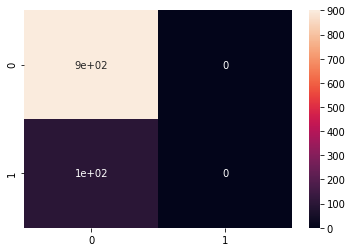

In [7]:
# confusion matrix поможет определить, сколько элементов в TP, TN, FP, FN
sns.heatmap(confusion_matrix(y_true, y_pred_0), annot=True)

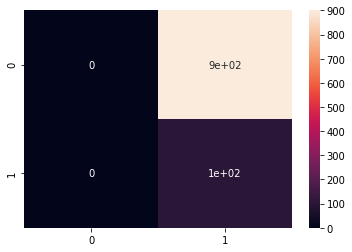

In [6]:
sns.heatmap(confusion_matrix(y_true, y_pred_1), annot=True)

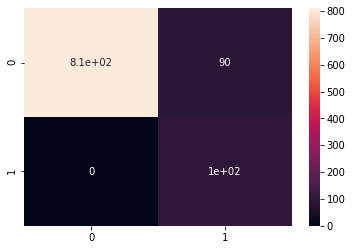

In [9]:
sns.heatmap(confusion_matrix(y_true, y_pred_10_0), annot=True)

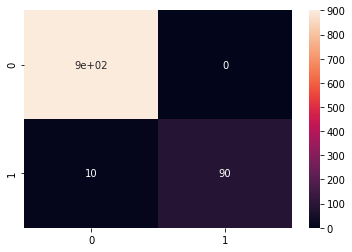

In [10]:
sns.heatmap(confusion_matrix(y_true, y_pred_10_1), annot=True)

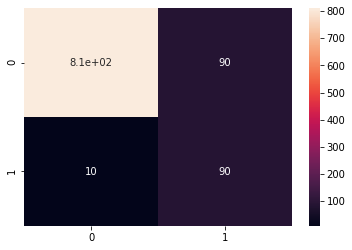

In [11]:
sns.heatmap(confusion_matrix(y_true, y_pred_10_both), annot=True)

Не все йогурты одинаково полезны, не все метрики одинаково хороши.

Разберем основные метрики классификации и поймем, в каких случаях они хороши, и что вообще показывают.

На повестке дня:
1. AUPRC
2. AUROC
3. F-measure

In [15]:
# AUROC

# Про AUROC часто говорят, как про альтернативу accuracy в случае несбалансированных классов,
# кто-то говорит, что AUROC не подходит для несбалансированных классов, а AUPRC подходит.
# Как всегда, все зависит от того, что мы хотим делать

# пример, когда все хорошо и, кажется, с разными классами все хорошо
print(roc_auc_score(y_true, y_pred_0, labels=1))
print(roc_auc_score(y_true, y_pred_1, labels=1))
print(roc_auc_score(y_true, y_pred_10_0, labels=1))
print(roc_auc_score(y_true, y_pred_10_1, labels=1))
print(roc_auc_score(y_true, y_pred_10_both, labels=1))

0.5
0.5
0.9500000000000001
0.95
0.9


In [3]:
# теперь рассмотрим такой пример

y_true = [0]*20 + [1]*5

# AUROC учитывает ранги объектов
# пусть все объекты негативного класса правильно классифицированны (вероятность меньше 0.5)
# один объект позитивного класса неправильно классифицирован, причем у него самый низкий ранг
y_pred = [0.2]*20 + [1]*4 + [0.1]*1
print(roc_auc_score(y_true, y_pred, labels=1))

# та же ситуация, только наоборот: все позитивные правильно классифицированы (вероятность больше 0.5)
# один объект негативного класса неправильно классифицирован, причем у него самый высокий ран
y_pred = [0.2]*19 + [0.9] + [0.8]*5
print(roc_auc_score(y_true, y_pred, labels=1))

# сложный пример, но тут нужно его немного вкурить
# если смотреть на ранги с самого высокого к самому низкому, то идет 4 объекта класса 1,
# 5 объектов класса 0, 1 объект класса 1, 15 объектов класса 0.
y_pred = [0.2]*15 + [0.4]*5 + [1]*4 + [0.3]*1
print(roc_auc_score(y_true, y_pred, labels=1))

# в случае 2 и 3 одинаковый, так сказать, overlap предсказаний, и одинаковые результаты.
# зависит от классификатора, но есть тенденция к тому, чтобы чуть больше штрафовать за объекты меньшего класса.
# это не всегда полезно.

0.8
0.95
0.95


In [9]:
# AUPRC
y_pred = [0.2]*20 + [1]*4 + [0.1]*1
print(average_precision_score(y_true, y_pred, pos_label=1))

y_pred = [0.2]*19 + [0.9] + [0.8]*5
print(average_precision_score(y_true, y_pred, pos_label=1))
# штрафует за лишние позитивные (FP) примеры почти так же сильно, как и за ненайденные позитивные (FN)

y_pred = [0.2]*15 + [0.4]*5 + [1]*4 + [0.3]*1
print(average_precision_score(y_true, y_pred, pos_label=1))

# тут понятно, что AUPRC сильнее 

0.8400000000000001
0.8333333333333334
0.9


In [7]:
average_precision_score(y_true, y_pred, pos_label=1)

0.9

In [ ]:
# F-measure
# повторить то, что было на лекции

## 1.2 One-class classification

Еще один способ делать классификацию, когда классы сильно несбалансированны. 

One-class classification - разделение данных на данные, принадлежание классу и остальные.

Когда one-class classification подходит:
* Когда выбросов сильно меньше, чем данных из класса
* Когда данные из меньшего класса не имеют особой структуры

В чем различия между binary и one-class классификациями:
* В бинарной классификации хотим разделить данные на две группы, внутри каждой группы данные похожи
* В one-class фокусируемся на том, чтобы выделить один класс данных, которые похожи друг на друга, у которых не очень высокая дисперсия (нам плевать на то, как выглядит вторая группа)

Зачем:
* Novelty detection - хотим уметь находить новые данные
* Outlier detection - все, что не наш класс - выбросы
* Open-set recognition. Пусть у нас есть база данных с картинками животных и каждой новой картинке мы подвешиваем тег. У нас есть котики, собачки, кролики и попугайчики (N известных классов). Но тут нам внезапно загрузили картинку с хомячком. Хотим вот такие картинки распознавать в отдельный класс (open-set). В one-class classification рассматривается экстримальный случай такой задачи при N=1

![photo_2021-09-13 18.09.57.jpeg](attachment:./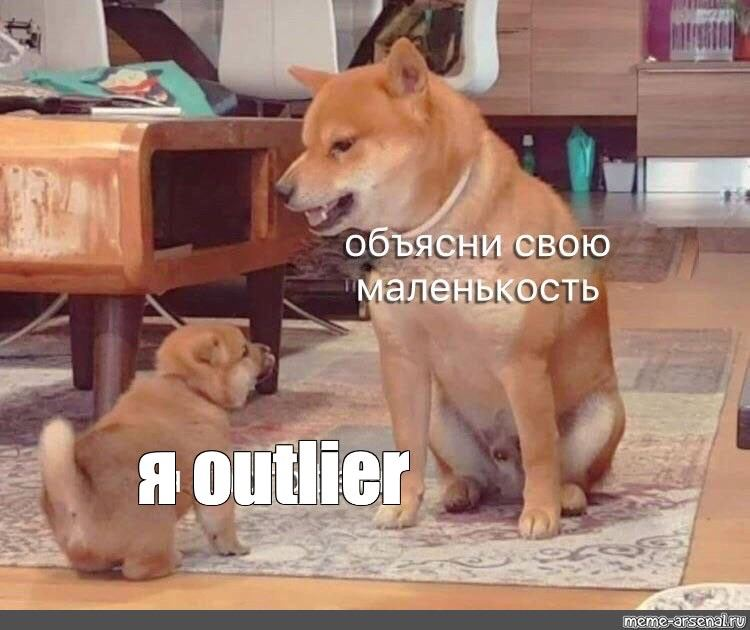)

![telegram-cloud-photo-size-2-5335016454933821512-y.jpg](attachment:./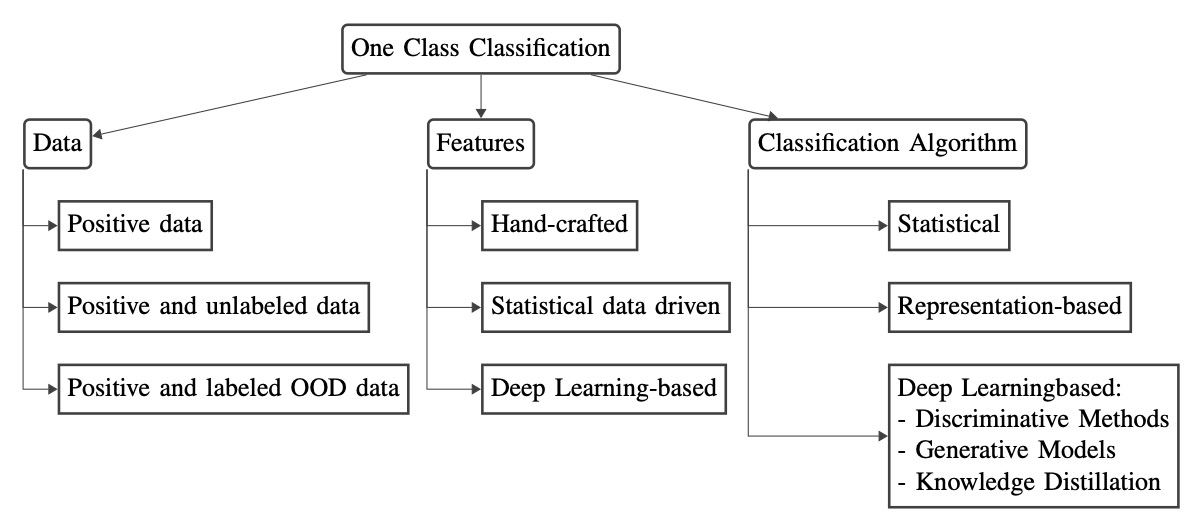)

## Что почитать
### По метрикам
Не видела ни одной прям хорошей статьи по AUROC и AUPRC, но можно немножечко упороться и
почитать вот эту статью

The Relationship Between Precision-Recall and ROC Curves, Jesse Davis & Mark Goadrich


### One class:
Для тех, кому интересно разобраться, что это такое и с чем это едят.

* One-Class Classification: A Survey, Perera
* A Unifying Review of Deep and Shallow Anomaly Detection, Ruff et al
* CLASSIFICATION-BASED ANOMALY DETECTION FOR GENERAL DATA, Bergman
* One-Class Convolutional Neural Network, Poojan Oza
* DEEP LEARNING FOR ANOMALY DETECTION: A SURVEY, Chalapathy